# RNN with GRU Model Training for Brain Tumor Classification

This notebook trains a hybrid CNN-GRU model to classify brain MRI images into 4 categories:
- **NO_TUMOR**: Healthy brain (no tumor detected)
- **GLIOMA**: Glioma tumor type
- **MENINGIOMA**: Meningioma tumor type
- **PITUITARY**: Pituitary tumor type

## Overview

This notebook implements a **CNN-GRU hybrid architecture**:
1. **CNN Feature Extractor**: Extracts spatial features from images using convolutional layers
2. **GRU Layers**: Processes the extracted features as sequences (GRU is faster and more efficient than LSTM)
3. **Fully Connected Layers**: Final classification into 4 classes

This approach combines the spatial feature extraction capabilities of CNNs with the sequential modeling power of GRUs.

## Requirements

Make sure you have installed all required packages:
```bash
pip install torch torchvision seaborn pandas scikit-learn matplotlib numpy tqdm
```

Or install from requirements.txt:
```bash
pip install -r requirements.txt
```

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import os
import random
from pathlib import Path

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Ti


## 2. Configuration

In [2]:
# Configuration
DATA_DIR = 'data/vgg16_classification'
MODEL_DIR = 'models/gru'
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, 'gru_brain_tumor_classifier.pth')
HISTORY_SAVE_PATH = os.path.join(MODEL_DIR, 'gru_training_history.csv')

# Training hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
NUM_CLASSES = 4

# Class names
CLASS_NAMES = ['NO_TUMOR', 'GLIOMA', 'MENINGIOMA', 'PITUITARY']

# Create models directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

## 3. Data Loading and Preprocessing

In [3]:
# Data transforms
# Training: only normalization (augmentation already applied via augment_training_data.py)
# Use train_augmented directory which contains pre-augmented images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test: only normalization (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
# Use train_augmented directory (created by augment_training_data.py)
# If train_augmented doesn't exist, fall back to train directory
train_dir = os.path.join(DATA_DIR, 'train_augmented')
if not os.path.exists(train_dir):
    print(f"Warning: {train_dir} not found. Using 'train' directory instead.")
    print("Run 'python augment_training_data.py' first to create augmented training data.")
    train_dir = os.path.join(DATA_DIR, 'train')
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset = ImageFolder(root=os.path.join(DATA_DIR, 'val'), transform=val_test_transform)
test_dataset = ImageFolder(root=os.path.join(DATA_DIR, 'test'), transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Class names: {train_dataset.classes}')

Train samples: 29496
Validation samples: 1053
Test samples: 1054
Number of classes: 4
Class names: ['GLIOMA', 'MENINGIOMA', 'NO_TUMOR', 'PITUITARY']


### 3.1 Class Distribution

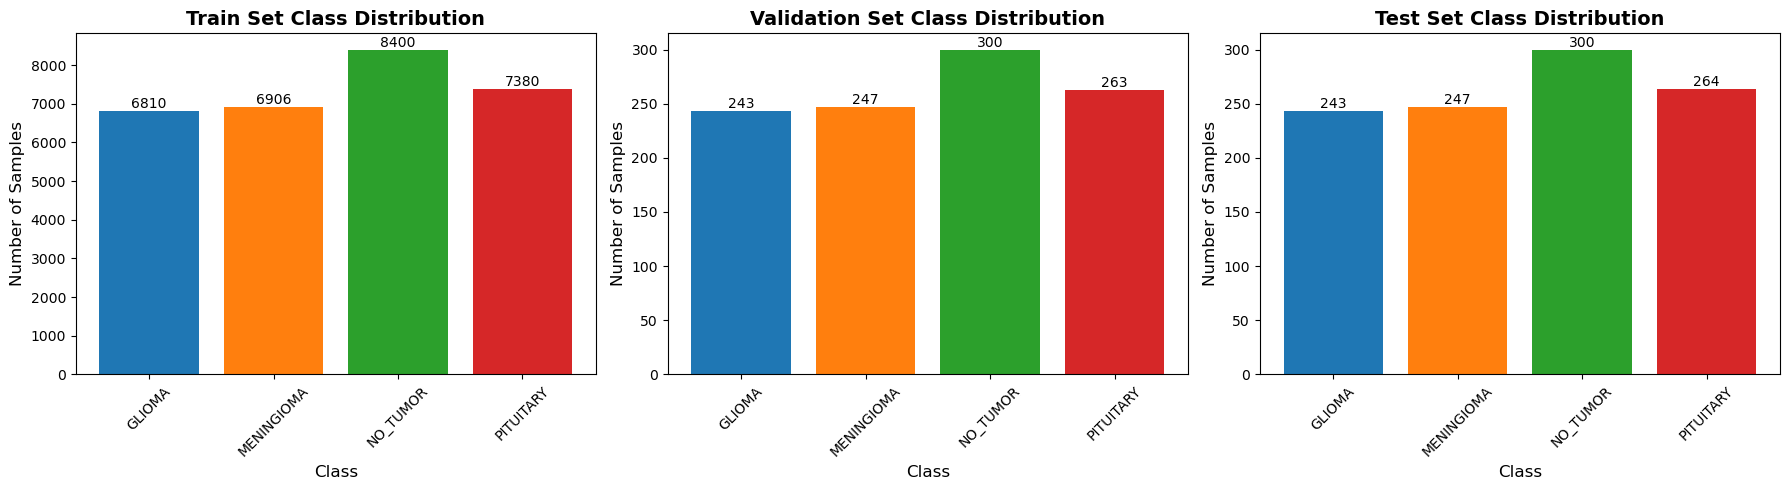


Class Distribution Summary:
Class           Train      Val        Test      
--------------------------------------------------
NO_TUMOR        8400       300        300       
GLIOMA          6810       243        243       
MENINGIOMA      6906       247        247       
PITUITARY       7380       263        264       


In [4]:
# Display class distribution
def get_class_distribution(dataset):
    class_counts = {}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

train_dist = get_class_distribution(train_dataset)
val_dist = get_class_distribution(val_dataset)
test_dist = get_class_distribution(test_dataset)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (dist, title) in enumerate([(train_dist, 'Train'), (val_dist, 'Validation'), (test_dist, 'Test')]):
    classes = list(dist.keys())
    counts = list(dist.values())
    axes[idx].bar(classes, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[idx].set_title(f'{title} Set Class Distribution', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Class', fontsize=12)
    axes[idx].set_ylabel('Number of Samples', fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    for i, v in enumerate(counts):
        axes[idx].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary
print("\nClass Distribution Summary:")
print(f"{'Class':<15} {'Train':<10} {'Val':<10} {'Test':<10}")
print("-" * 50)
for class_name in CLASS_NAMES:
    print(f"{class_name:<15} {train_dist.get(class_name, 0):<10} {val_dist.get(class_name, 0):<10} {test_dist.get(class_name, 0):<10}")

## 4. CNN-GRU Model Architecture

In [5]:
class BrainTumorCNNGRU(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNNGRU, self).__init__()
        
        # CNN Feature Extractor
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Adaptive pooling to get fixed size feature maps
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Flatten spatial dimensions for GRU
        # After pooling: 128 channels * 7 * 7 = 6272 features
        self.feature_size = 128 * 7 * 7
        
        # GRU layers (GRU is faster and more efficient than LSTM)
        self.gru = nn.GRU(input_size=self.feature_size, hidden_size=256, 
                         num_layers=2, batch_first=True, dropout=0.3)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # CNN feature extraction
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        
        # Reshape for GRU: (batch, channels, height, width) -> (batch, seq_len, features)
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.feature_size)  # (batch, 1, feature_size)
        
        # GRU processing
        gru_out, h_n = self.gru(x)
        # Use the last output
        gru_out = gru_out[:, -1, :]  # (batch, hidden_size)
        
        # Classification
        x = self.fc(gru_out)
        return x

# Initialize model
model = BrainTumorCNNGRU(num_classes=NUM_CLASSES).to(device)

# Print model architecture
print("CNN-GRU Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

CNN-GRU Model Architecture:
BrainTumorCNNGRU(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0

## 5. Training Configuration

In [7]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print(f"Learning rate scheduler: ReduceLROnPlateau")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Learning rate scheduler: ReduceLROnPlateau


## 6. Training Loop

In [8]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validating'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [9]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0
early_stopping_patience = 10

print("Starting training...")
print(f"Training for {NUM_EPOCHS} epochs")
print("-" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'history': history
        }, MODEL_SAVE_PATH)
        print(f"Saved best model (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "=" * 60)
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training...
Training for 50 epochs
------------------------------------------------------------

Epoch 1/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.82it/s]


Train Loss: 0.8539, Train Acc: 65.11%
Val Loss: 0.5895, Val Acc: 77.11%
Learning Rate: 0.001000
Saved best model (Val Acc: 77.11%)

Epoch 2/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.78it/s]


Train Loss: 0.6139, Train Acc: 77.40%
Val Loss: 0.3530, Val Acc: 87.75%
Learning Rate: 0.001000
Saved best model (Val Acc: 87.75%)

Epoch 3/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.92it/s]


Train Loss: 0.5162, Train Acc: 81.18%
Val Loss: 0.3124, Val Acc: 88.51%
Learning Rate: 0.001000
Saved best model (Val Acc: 88.51%)

Epoch 4/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.85it/s]


Train Loss: 0.4505, Train Acc: 83.75%
Val Loss: 0.3789, Val Acc: 86.04%
Learning Rate: 0.001000

Epoch 5/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.88it/s]


Train Loss: 0.4048, Train Acc: 85.30%
Val Loss: 0.2810, Val Acc: 90.69%
Learning Rate: 0.001000
Saved best model (Val Acc: 90.69%)

Epoch 6/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.86it/s]


Train Loss: 0.3854, Train Acc: 86.16%
Val Loss: 0.7027, Val Acc: 77.02%
Learning Rate: 0.001000

Epoch 7/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.65it/s]


Train Loss: 0.3510, Train Acc: 87.59%
Val Loss: 0.2266, Val Acc: 92.02%
Learning Rate: 0.001000
Saved best model (Val Acc: 92.02%)

Epoch 8/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.71it/s]


Train Loss: 0.3233, Train Acc: 88.46%
Val Loss: 0.2573, Val Acc: 91.36%
Learning Rate: 0.001000

Epoch 9/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.79it/s]


Train Loss: 0.2920, Train Acc: 89.36%
Val Loss: 0.2229, Val Acc: 92.40%
Learning Rate: 0.001000
Saved best model (Val Acc: 92.40%)

Epoch 10/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.76it/s]


Train Loss: 0.2625, Train Acc: 90.54%
Val Loss: 0.1983, Val Acc: 92.50%
Learning Rate: 0.001000
Saved best model (Val Acc: 92.50%)

Epoch 11/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.83it/s]


Train Loss: 0.2372, Train Acc: 91.79%
Val Loss: 0.1620, Val Acc: 94.87%
Learning Rate: 0.001000
Saved best model (Val Acc: 94.87%)

Epoch 12/50


Validating: 100%|██████████| 33/33 [00:00<00:00, 33.00it/s]


Train Loss: 0.2263, Train Acc: 92.04%
Val Loss: 0.1669, Val Acc: 94.40%
Learning Rate: 0.001000

Epoch 13/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.69it/s]


Train Loss: 0.2101, Train Acc: 92.78%
Val Loss: 0.1459, Val Acc: 95.54%
Learning Rate: 0.001000
Saved best model (Val Acc: 95.54%)

Epoch 14/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.78it/s]


Train Loss: 0.1836, Train Acc: 93.82%
Val Loss: 0.1503, Val Acc: 94.68%
Learning Rate: 0.001000

Epoch 15/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.67it/s]


Train Loss: 0.1679, Train Acc: 94.24%
Val Loss: 0.7079, Val Acc: 81.58%
Learning Rate: 0.001000

Epoch 16/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.78it/s]


Train Loss: 0.1681, Train Acc: 94.34%
Val Loss: 0.1462, Val Acc: 96.01%
Learning Rate: 0.001000
Saved best model (Val Acc: 96.01%)

Epoch 17/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.66it/s]


Train Loss: 0.1474, Train Acc: 94.96%
Val Loss: 0.1287, Val Acc: 96.58%
Learning Rate: 0.001000
Saved best model (Val Acc: 96.58%)

Epoch 18/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.72it/s]


Train Loss: 0.1344, Train Acc: 95.48%
Val Loss: 0.1801, Val Acc: 94.21%
Learning Rate: 0.001000

Epoch 19/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.70it/s]


Train Loss: 0.1205, Train Acc: 96.01%
Val Loss: 0.0860, Val Acc: 97.06%
Learning Rate: 0.001000
Saved best model (Val Acc: 97.06%)

Epoch 20/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.78it/s]


Train Loss: 0.1175, Train Acc: 96.17%
Val Loss: 0.0992, Val Acc: 97.63%
Learning Rate: 0.001000
Saved best model (Val Acc: 97.63%)

Epoch 21/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.60it/s]


Train Loss: 0.1071, Train Acc: 96.51%
Val Loss: 0.1329, Val Acc: 96.01%
Learning Rate: 0.001000

Epoch 22/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.76it/s]


Train Loss: 0.0983, Train Acc: 96.75%
Val Loss: 0.1359, Val Acc: 96.58%
Learning Rate: 0.001000

Epoch 23/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.71it/s]


Train Loss: 0.0853, Train Acc: 97.14%
Val Loss: 0.0949, Val Acc: 97.25%
Learning Rate: 0.001000

Epoch 24/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.94it/s]


Train Loss: 0.0869, Train Acc: 97.16%
Val Loss: 0.1021, Val Acc: 96.77%
Learning Rate: 0.001000

Epoch 25/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.13it/s]


Train Loss: 0.0787, Train Acc: 97.43%
Val Loss: 0.1327, Val Acc: 97.25%
Learning Rate: 0.000500

Epoch 26/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.67it/s]


Train Loss: 0.0483, Train Acc: 98.41%
Val Loss: 0.0749, Val Acc: 97.82%
Learning Rate: 0.000500
Saved best model (Val Acc: 97.82%)

Epoch 27/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.43it/s]


Train Loss: 0.0404, Train Acc: 98.69%
Val Loss: 0.0985, Val Acc: 97.82%
Learning Rate: 0.000500

Epoch 28/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.48it/s]


Train Loss: 0.0366, Train Acc: 98.80%
Val Loss: 0.1149, Val Acc: 97.44%
Learning Rate: 0.000500

Epoch 29/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.70it/s]


Train Loss: 0.0317, Train Acc: 99.00%
Val Loss: 0.1141, Val Acc: 98.01%
Learning Rate: 0.000500
Saved best model (Val Acc: 98.01%)

Epoch 30/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.85it/s]


Train Loss: 0.0336, Train Acc: 98.89%
Val Loss: 0.0831, Val Acc: 97.91%
Learning Rate: 0.000500

Epoch 31/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.72it/s]


Train Loss: 0.0304, Train Acc: 99.00%
Val Loss: 0.1086, Val Acc: 98.01%
Learning Rate: 0.000500

Epoch 32/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.78it/s]


Train Loss: 0.0271, Train Acc: 99.15%
Val Loss: 0.0860, Val Acc: 98.39%
Learning Rate: 0.000250
Saved best model (Val Acc: 98.39%)

Epoch 33/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.78it/s]


Train Loss: 0.0140, Train Acc: 99.51%
Val Loss: 0.1004, Val Acc: 98.20%
Learning Rate: 0.000250

Epoch 34/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.98it/s]


Train Loss: 0.0136, Train Acc: 99.56%
Val Loss: 0.1238, Val Acc: 97.72%
Learning Rate: 0.000250

Epoch 35/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.79it/s]


Train Loss: 0.0129, Train Acc: 99.55%
Val Loss: 0.1074, Val Acc: 98.01%
Learning Rate: 0.000250

Epoch 36/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.83it/s]


Train Loss: 0.0137, Train Acc: 99.54%
Val Loss: 0.0964, Val Acc: 98.01%
Learning Rate: 0.000250

Epoch 37/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.94it/s]


Train Loss: 0.0100, Train Acc: 99.64%
Val Loss: 0.1539, Val Acc: 96.96%
Learning Rate: 0.000250

Epoch 38/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.80it/s]


Train Loss: 0.0123, Train Acc: 99.63%
Val Loss: 0.1093, Val Acc: 98.10%
Learning Rate: 0.000125

Epoch 39/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.81it/s]


Train Loss: 0.0077, Train Acc: 99.77%
Val Loss: 0.1205, Val Acc: 98.10%
Learning Rate: 0.000125

Epoch 40/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.85it/s]


Train Loss: 0.0057, Train Acc: 99.82%
Val Loss: 0.1087, Val Acc: 98.10%
Learning Rate: 0.000125

Epoch 41/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.86it/s]


Train Loss: 0.0055, Train Acc: 99.85%
Val Loss: 0.0975, Val Acc: 98.39%
Learning Rate: 0.000125

Epoch 42/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.72it/s]


Train Loss: 0.0059, Train Acc: 99.77%
Val Loss: 0.1153, Val Acc: 98.48%
Learning Rate: 0.000125
Saved best model (Val Acc: 98.48%)

Epoch 43/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.78it/s]


Train Loss: 0.0061, Train Acc: 99.79%
Val Loss: 0.1153, Val Acc: 98.20%
Learning Rate: 0.000125

Epoch 44/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.86it/s]


Train Loss: 0.0064, Train Acc: 99.80%
Val Loss: 0.1236, Val Acc: 98.29%
Learning Rate: 0.000063

Epoch 45/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.66it/s]


Train Loss: 0.0034, Train Acc: 99.90%
Val Loss: 0.1089, Val Acc: 98.48%
Learning Rate: 0.000063

Epoch 46/50


Validating: 100%|██████████| 33/33 [00:00<00:00, 33.15it/s]


Train Loss: 0.0041, Train Acc: 99.88%
Val Loss: 0.1077, Val Acc: 98.39%
Learning Rate: 0.000063

Epoch 47/50


Validating: 100%|██████████| 33/33 [00:01<00:00, 32.88it/s]


Train Loss: 0.0028, Train Acc: 99.91%
Val Loss: 0.1012, Val Acc: 98.29%
Learning Rate: 0.000063

Epoch 48/50


Validating: 100%|██████████| 33/33 [00:00<00:00, 37.45it/s]


Train Loss: 0.0027, Train Acc: 99.91%
Val Loss: 0.1278, Val Acc: 98.01%
Learning Rate: 0.000063

Epoch 49/50


Validating: 100%|██████████| 33/33 [00:00<00:00, 33.48it/s]


Train Loss: 0.0030, Train Acc: 99.91%
Val Loss: 0.1282, Val Acc: 98.29%
Learning Rate: 0.000063

Epoch 50/50


Validating: 100%|██████████| 33/33 [00:00<00:00, 36.89it/s]

Train Loss: 0.0023, Train Acc: 99.92%
Val Loss: 0.1306, Val Acc: 98.29%
Learning Rate: 0.000031

Training completed!
Best validation accuracy: 98.48%


### 6.1 Save Training History

In [10]:
# Save training history to CSV
history_df = pd.DataFrame(history)
history_df.to_csv(HISTORY_SAVE_PATH, index=False)
print(f"Training history saved to {HISTORY_SAVE_PATH}")

Training history saved to models/gru/gru_training_history.csv


## 7. Training Curves Visualization

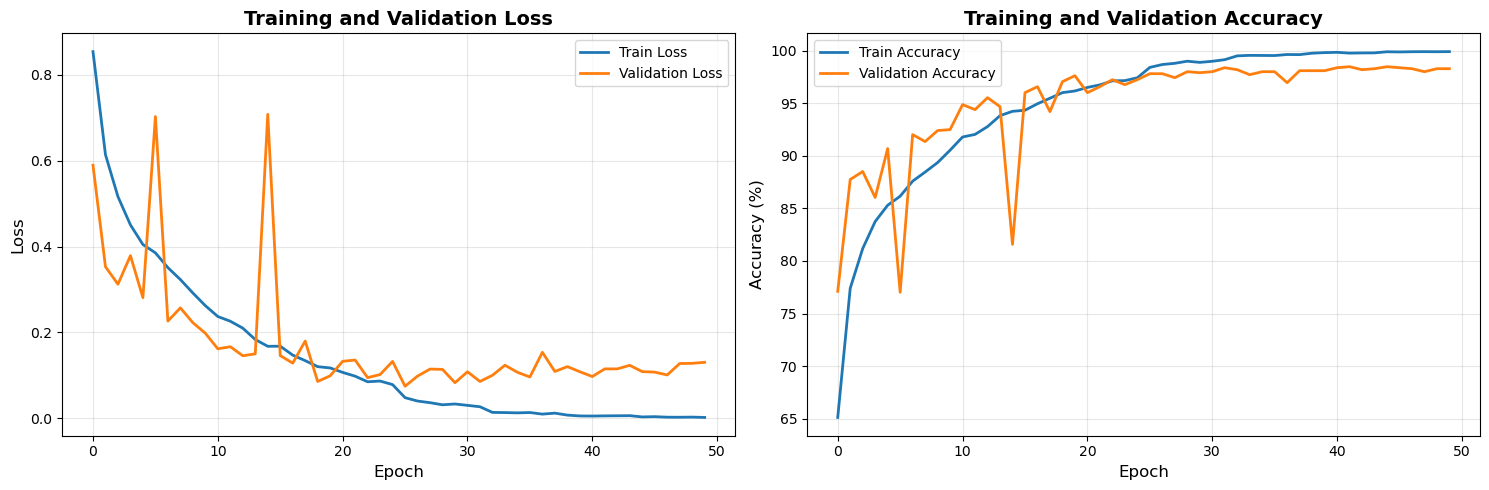

In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'gru_training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

## 8. Load Best Model and Evaluate on Test Set

In [12]:
# Load best model
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Define y_true and y_pred for evaluation
y_true = all_labels
y_pred = all_preds

# Calculate and print overall accuracy score
accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy Score: {accuracy:.4f} ({accuracy*100:.2f}%)")

Loaded best model from epoch 42
Best validation accuracy: 98.48%


Testing: 100%|██████████| 33/33 [00:01<00:00, 31.28it/s]


Overall Accuracy Score: 0.9772 (97.72%)


## 9. Confusion Matrix

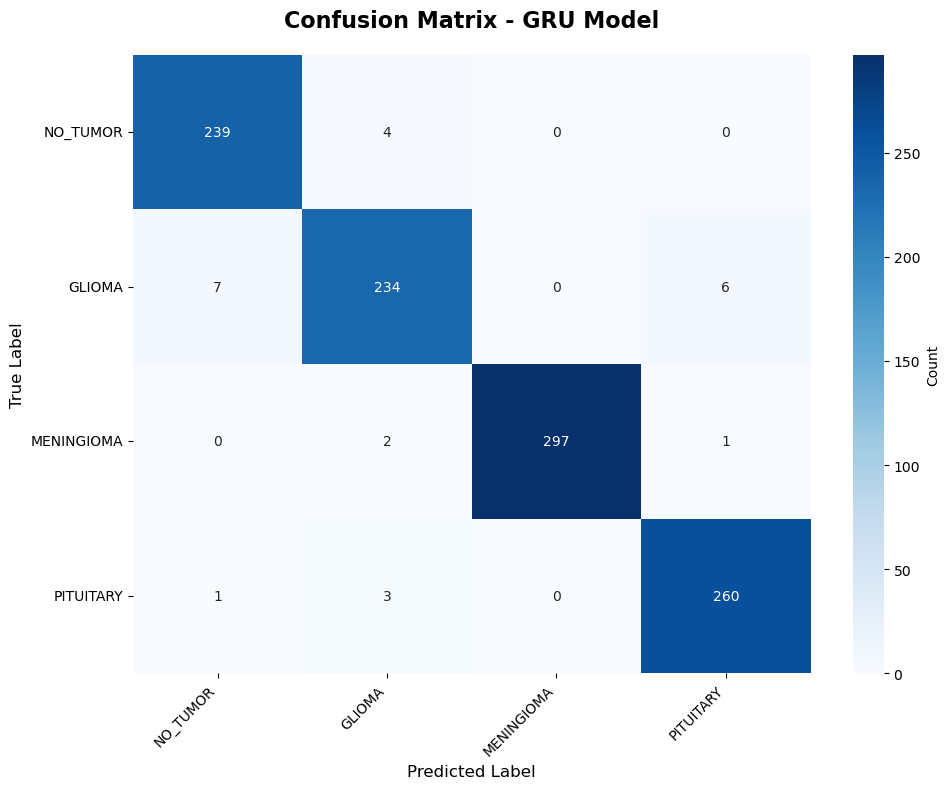


Confusion Matrix:
               NO_TUMOR       GLIOMA         MENINGIOMA     PITUITARY      
NO_TUMOR       239            4              0              0              
GLIOMA         7              234            0              6              
MENINGIOMA     0              2              297            1              
PITUITARY      1              3              0              260            


In [13]:
# Generate confusion matrix using y_true and y_pred
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - GRU Model', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'gru_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print confusion matrix as table
print("\nConfusion Matrix:")
print(f"{'':<15}", end='')
for name in CLASS_NAMES:
    print(f"{name:<15}", end='')
print()
for i, name in enumerate(CLASS_NAMES):
    print(f"{name:<15}", end='')
    for j in range(len(CLASS_NAMES)):
        print(f"{cm[i][j]:<15}", end='')
    print()

## 10. Classification Report

In [14]:
# Calculate and print the full classification report (showing precision, recall, and f1-score for all classes)
print("Full Classification Report:")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
print("=" * 70)

# Also generate report as dictionary for detailed access
report = classification_report(y_true, y_pred, 
                                target_names=CLASS_NAMES, 
                                output_dict=True)

print("Classification Report:")
print("=" * 70)
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)

for class_name in CLASS_NAMES:
    metrics = report[class_name]
    print(f"{class_name:<15} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} "
          f"{metrics['f1-score']:<12.4f} {int(metrics['support']):<10})")

print("-" * 70)
print(f"{'Accuracy':<15} {'':<12} {'':<12} {report['accuracy']:<12.4f} {len(y_true):<10}")
print(f"{'Macro Avg':<15} {report['macro avg']['precision']:<12.4f} "
      f"{report['macro avg']['recall']:<12.4f} {report['macro avg']['f1-score']:<12.4f} "
      f"{int(report['macro avg']['support']):<10}")
print(f"{'Weighted Avg':<15} {report['weighted avg']['precision']:<12.4f} "
      f"{report['weighted avg']['recall']:<12.4f} {report['weighted avg']['f1-score']:<12.4f} "
      f"{int(report['weighted avg']['support']):<10}")
print("=" * 70)

# Save report to file
report_path = os.path.join(MODEL_DIR, 'gru_classification_report.txt')
with open(report_path, 'w') as f:
    f.write(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
print(f"\nClassification report saved to {report_path}")

Full Classification Report:
              precision    recall  f1-score   support

    NO_TUMOR       0.97      0.98      0.98       243
      GLIOMA       0.96      0.95      0.96       247
  MENINGIOMA       1.00      0.99      0.99       300
   PITUITARY       0.97      0.98      0.98       264

    accuracy                           0.98      1054
   macro avg       0.98      0.98      0.98      1054
weighted avg       0.98      0.98      0.98      1054

Classification Report:
Class           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
NO_TUMOR        0.9676       0.9835       0.9755       243       )
GLIOMA          0.9630       0.9474       0.9551       247       )
MENINGIOMA      1.0000       0.9900       0.9950       300       )
PITUITARY       0.9738       0.9848       0.9793       264       )
----------------------------------------------------------------------
Accuracy                              

## 11. Sample Predictions Visualization

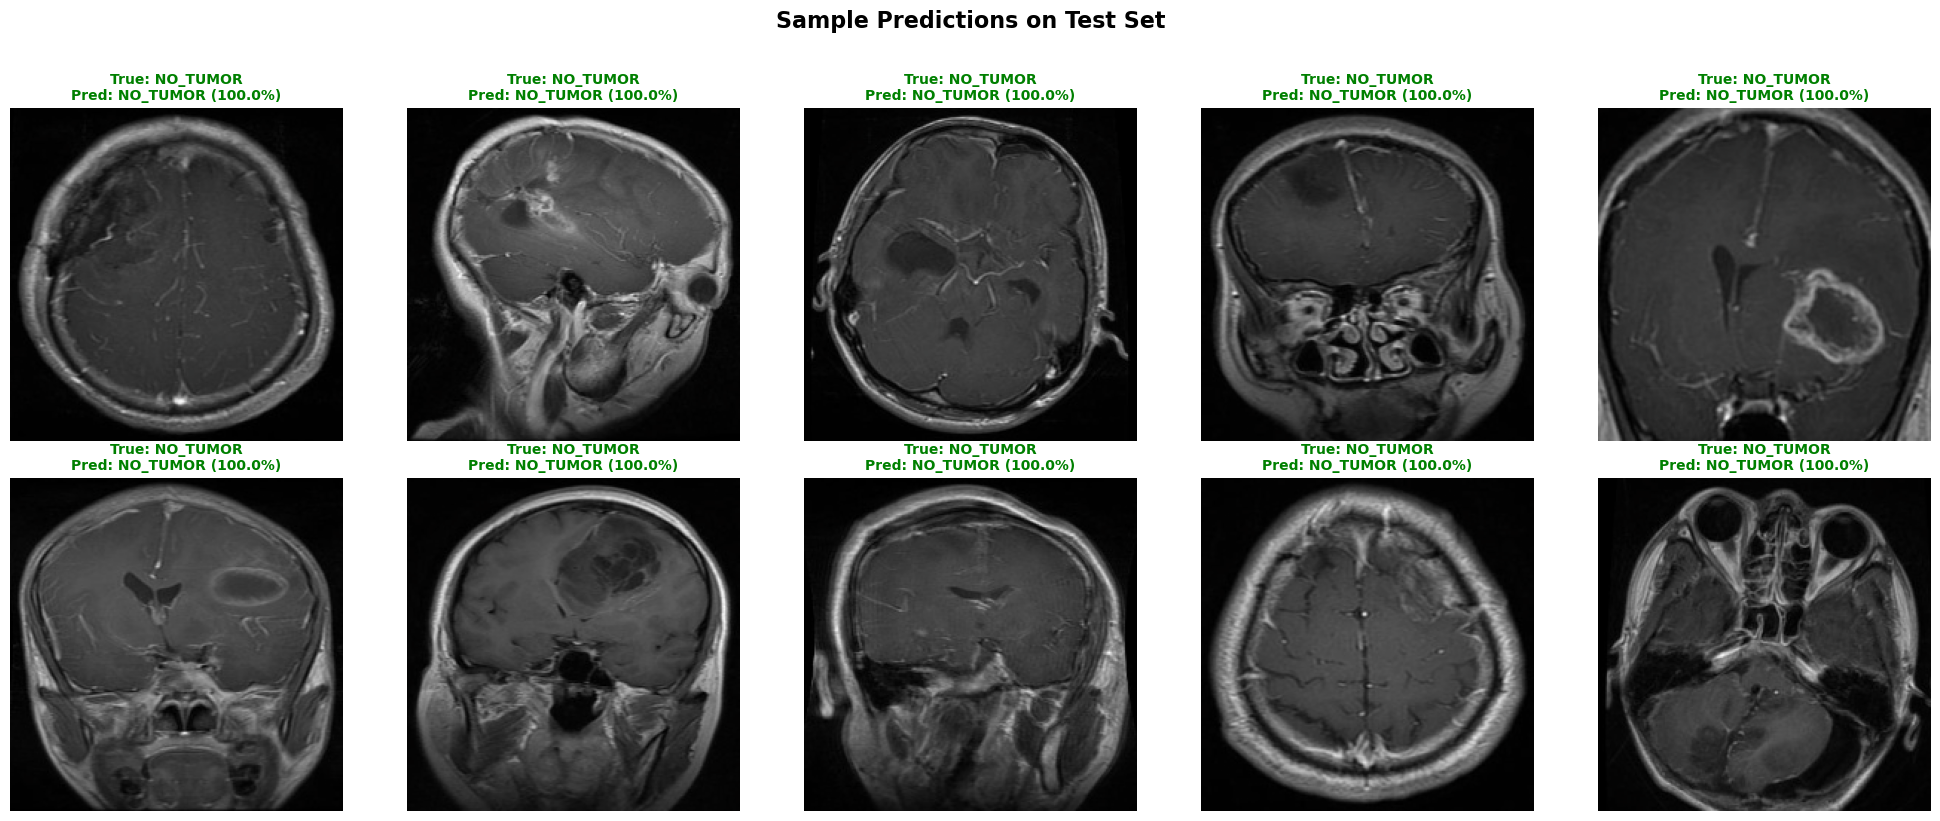

In [15]:
# Visualize sample predictions
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

# Denormalize for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

for idx in range(min(10, len(images))):
    img = images[idx].cpu()
    img = img * std + mean  # Denormalize
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0).numpy()
    
    true_label = CLASS_NAMES[labels[idx]]
    pred_label = CLASS_NAMES[predicted[idx]]
    confidence = probabilities[idx][predicted[idx]].item() * 100
    
    # Color: green if correct, red if wrong
    color = 'green' if predicted[idx] == labels[idx] else 'red'
    
    axes[idx].imshow(img)
    axes[idx].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                        color=color, fontsize=10, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'gru_sample_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()

## 12. Summary

### Model Performance Summary:
- **Test Accuracy**: Calculated above
- **Best Validation Accuracy**: Calculated above
- **Model saved to**: `models/gru/gru_brain_tumor_classifier.pth`
- **Training history saved to**: `models/gru/gru_training_history.csv`

### Files Generated:
1. Trained model: `models/gru/gru_brain_tumor_classifier.pth`
2. Training history: `models/gru/gru_training_history.csv`
3. Training curves: `models/gru/gru_training_curves.png`
4. Confusion matrix: `models/gru/gru_confusion_matrix.png`
5. Classification report: `models/gru/gru_classification_report.txt`
6. Sample predictions: `models/gru/gru_sample_predictions.png`

All files are saved in the `models/gru/` directory and can be used for reporting and further analysis.

### GRU vs LSTM:
- **GRU** is generally faster and uses less memory than LSTM
- **GRU** has fewer parameters (no cell state, only hidden state)
- **LSTM** may capture longer dependencies but GRU often performs similarly with better efficiency
- Both architectures are available for comparison: `train_rnn_lstm.ipynb` and `train_gru.ipynb`